In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd
import re
import warnings
import random
import matplotlib
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
from scipy.stats import linregress, spearmanr
import analysis_utils
from copy import deepcopy

# path to repository folder (data is stored here as well)
path = '..'
preds_loc = os.path.join(path, 'data', 'inference', 's461_mapped_preds_clusters.csv')

# default plotting settings
font = {'size'   : 18}
matplotlib.rc('font', **font)

# notebook display options
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 300

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

In [3]:
db = pd.read_csv(preds_loc).set_index(['uid', 'uid2'])
db_runtimes = db[[col for col in db.columns if 'runtime' in col]]

db = db.reset_index().rename({'uid': 'uid_'}, axis=1).rename({'uid2': 'uid'}, axis=1).set_index('uid')
# extract the runtimes for methods that have it (not currently used)
db_runtimes = db_runtimes.reset_index().rename({'uid': 'uid_'}, axis=1).rename({'uid2': 'uid'}, axis=1).set_index('uid')
print('getting cartesian predictions')
# assuming you have designated the repo location as the path
df_cart, df_cart_runtimes = analysis_utils.parse_rosetta_predictions(db, os.path.join(path, 'data', 'rosetta_predictions'), runtime=True)
try:
    db = db.join(df_cart.astype(float), how='left').reset_index().rename({'uid': 'uid2'}, axis=1).rename({'uid_': 'uid'}, axis=1).set_index(['uid', 'uid2'])
    db_runtimes = db_runtimes.join(df_cart_runtimes, how='left').reset_index().rename({'uid': 'uid2'}, axis=1).rename({'uid_': 'uid'}, axis=1).set_index(['uid', 'uid2'])
except ValueError:
    pass
db_runtimes['runtime_korpm'] = 0.0015

original_pred_cols = [c for c in db.columns if '_dir' in c and not 'runtime' in c and not 'pll' in c and not 'ddG' in c]
for col in ['PDB_dir', 'MUT_D_dir', 'SEC_STR_dir', 'SOL_ACC_dir']:
    original_pred_cols.remove(col)
original_pred_cols_reduced = deepcopy(original_pred_cols)
for col in [f'esm1v_{i}_dir' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)
for col in [f'msa_{i}_dir' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)

print(original_pred_cols_reduced)

# reduce the dataframe to only include immediately relevant information
cols = db.columns
drop = [col for col in db.columns if 'Unnamed' in col]
drop += [col for col in db.columns if 'pdb' in col]
drop += [col for col in db.columns if 'offset' in col]
db = db.drop(drop, axis=1)
db = db.drop(['PDB_dir', 'MUT_D_dir'], axis=1)

# extract predictions
cols = db.columns
incl = [col for col in db.columns if ('_dir' in col) or ('_inv' in col)]

#db_preds = db[incl].drop(['DDG_checked_dir', 'SEC_STR_dir', 'DDG_checked_inv', 'SEC_STR_inv', 'ddG_dir', 'ddG_inv'], axis=1)
#db_preds = db_preds.drop([col for col in db_preds.columns if 'runtime_' in col], axis=1).drop_duplicates()

# keep some originally included features
#db_feats = db[['multimer', 'TEMP', 'pH', 'SEC_STR_dir', 'SOL_ACC_dir']]

db_preds = db[original_pred_cols]

# use the S461 labels as the ground truth labels
db_ddg = db[['ddG_dir']]
db_clusters = db[['cluster']]

db_preds
#db_class.to_csv(os.path.join(path, 'data', 's461_mapped_preds_clusters.csv'))

getting cartesian predictions


ValueError: list.remove(x): x not in list

In [ ]:
neff = pd.read_csv(os.path.join(path, 'data', 'features', 'neff_s669.csv'), header=None).set_index(0) # todo / fix
neff.index.name = 'code'
neff.columns = ['neff']

db_feats_2 = pd.read_csv(os.path.join(path, 'data', 'features', 's669_local_mapped_feats.csv'))
db_feats_2['uid'] = db_feats_2['code'] + '_' + db_feats_2['position_orig'].astype(str) + db_feats_2['mutation']
db_feats_2['uid2'] = db_feats_2['code'] + '_' + db_feats_2['position'].astype(str) + db_feats_2['mutation']

db_feats_2 = db_feats_2.set_index('uid')
db_feats_2 = db_feats_2[['uid2', 'wild_type', 'on_interface', 'entropy', 'conservation', 'column_completeness', 'completeness_score', 'n_seqs', 'structure_length', 'multimer', 'SS',
                        'features', 'hbonds', 'saltbrs', 'b_factor', 'kdh_wt', 'kdh_mut', 'vol_wt', 'vol_mut', 'chg_wt', 'chg_mut', 'rel_ASA', 'is_nmr', 'pH', 'resolution',
                        'SOL_ACC_dir', 'SOL_ACC_inv']] #'residue_depth',

db_feats_2['on_interface'] = db_feats_2['on_interface'].astype(int)
db_feats_2['features'] = db_feats_2['features'].fillna("")#.apply(list)
#db_complete = db_complete.reset_index('uid').join(db_feats_2.set_index('uid'))
db_feats_2['delta_kdh'] = db_feats_2['kdh_mut'] - db_feats_2['kdh_wt']
db_feats_2['delta_vol'] = db_feats_2['vol_mut'] - db_feats_2['vol_wt']
db_feats_2['delta_chg'] = db_feats_2['chg_mut'] - db_feats_2['chg_wt']
db_feats_2['delta_asa'] = db_feats_2['SOL_ACC_inv'] - db_feats_2['SOL_ACC_dir']
db_feats_2['asa'] = db_feats_2['SOL_ACC_dir']
db_feats_2['to_proline'] = (db_feats_2.index.str[-1] == 'P').astype(int)
db_feats_2['to_glycine'] = (db_feats_2.index.str[-1] == 'G').astype(int)
db_feats_2['from_proline'] = db_feats_2['wild_type'] == 'P'
db_feats_2['from_glycine'] = db_feats_2['wild_type'] == 'G'
db_feats_2['to_alanine'] = (db_feats_2.index.str[-1] == 'A').astype(int)
db_feats_2['helix'] = db_feats_2['SS'] == 'H'
db_feats_2['bend'] = db_feats_2['SS'] == 'S'
db_feats_2['turn'] = db_feats_2['SS'] == 'T'
db_feats_2['coil'] = db_feats_2['SS'] == '-'
db_feats_2['strand'] = db_feats_2['SS'] == 'E'
#db_feats_2['xray_else_NMR'] = db_feats_2['nmr_xray'].str.contains('X-RAY')
db_feats_2['active_site'] = db_feats_2['features'].str.contains('ACT_SITE')
db_feats_2['resolution'] = db_feats_2['resolution'].fillna('').apply(lambda x: analysis_utils.extract_decimal_number(x))
#db_feats_2['mpnn_median_dir'] = db_feats_2[['mpnn_20_021_dir', 'mpnn_20_022_dir', 'mpnn_20_019_dir']].mean(axis=1)
db_feats_2 = db_feats_2.drop(['kdh_wt', 'kdh_mut', 'vol_wt', 'vol_mut', 'chg_wt', 'chg_mut', 'features', 'SS', 'wild_type'], axis=1)
# 'mpnn_20_021_dir', 'mpnn_20_022_dir', 'mpnn_20_019_dir', 'mpnn_10_dir', 'mpnn_30_dir', 'mpnn_30_03_dir', 'mpnn_20_02_dir',
db_feats_2['code'] = db_feats_2.index.str[:4]
db_feats_2 = db_feats_2.reset_index().merge(neff['neff'].dropna(), on='code', how='left').drop('code', axis=1)#.set_index('uid')
db_feats_2['neff'] = db_feats_2['neff'].fillna(0)
db_feats_2 = db_feats_2.groupby('uid').max()
db_feats_2 = db_feats_2.reset_index().set_index(['uid', 'uid2'])
db_feats_2

,,on_interface,entropy,conservation,column_completeness,completeness_score,n_seqs,structure_length,multimer,hbonds,saltbrs,...,from_proline,from_glycine,to_alanine,helix,bend,turn,coil,strand,active_site,neff
uid,uid2,,,,,,,,,,,,,,,,,,,,,
1A0F_11A,1A0F_11A,0,1.918516,31.774726,NaN,NaN,NaN,201,2,2.0,0.0,...,False,False,1,False,False,True,False,False,False,46810.256843
1A7V_104H,1A7V_104H,0,2.193564,37.211855,0.997622,0.951590,5466.0,125,1,1.0,0.0,...,False,False,0,True,False,False,False,False,False,3970.041972
1A7V_13H,1A7V_13H,0,2.031656,42.645445,1.000000,0.951590,5466.0,125,1,2.0,0.0,...,False,False,0,True,False,False,False,False,False,3970.041972
1A7V_20H,1A7V_20H,0,1.745063,26.491035,0.998536,0.951590,5466.0,125,1,3.0,1.0,...,False,False,0,True,False,False,False,False,False,3970.041972
1A7V_31H,1A7V_31H,0,1.840137,0.676912,0.858580,0.951590,5466.0,125,1,0.0,0.0,...,False,False,0,False,False,False,True,False,False,3970.041972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5JXB_329P,5JXB_25P,0,0.890326,78.325123,1.000000,0.931715,406.0,117,2,0.0,0.0,...,False,False,0,False,True,False,False,False,False,186.248966
5OAQ_429H,5OAQ_199H,0,0.269352,93.805310,0.958702,0.920096,339.0,204,2,2.0,0.0,...,False,False,0,False,False,False,False,True,False,151.512613
5VP3_128G,5VP3_128G,0,0.000000,100.000000,1.000000,0.993528,3.0,195,1,3.0,0.0,...,False,False,0,True,False,False,False,False,False,1.000000


Detected 13 interface mutations


,,KORPMD_dir,EvoD_dir,Dyna2D_dir,ACDC-NN-Seq_dir,ACDC-NN_dir,DDG_checked_dir,DDGun3D_dir,DDGun_dir,DUET_dir,Dynamut_dir,...,mpnn_oracle_dir,mpnn_mean_dir,esmif_mean_dir,mif_mean_dir,esm2_mean_dir,random_dir,random_inv,delta_kdh,delta_vol,rel_ASA
uid,uid2,,,,,,,,,,,,,,,,,,,,,
1A0F_11A,1A0F_11A,0.138,-0.37,0.545,0.041723,0.225406,-1.800,0.5,0.0,-0.466,0.545,...,-3.316990,-2.161944,-0.018018,-6.962128,-6.578033,-0.276811,-0.274803,2.6,-0.60,0.000000
1BA3_461D,1BA3_457D,-1.065,-0.77,0.160,-0.447964,-0.230352,-1.745,-1.2,-1.4,-1.757,0.160,...,-5.257127,-3.510182,-0.011513,-5.899839,-6.044271,0.017008,-0.312258,-0.3,-1.88,0.190217
1BA3_489D,1BA3_485D,0.270,0.96,-0.193,-0.000271,-0.040138,0.287,-0.1,-0.7,-0.252,-0.193,...,1.006858,1.273798,0.004294,1.124316,-0.746243,-0.114167,-0.363837,-0.3,-1.88,1.000000
1BA3_489K,1BA3_485K,0.398,1.12,0.190,0.006583,0.201055,-0.287,-0.1,-0.9,0.358,0.190,...,2.940507,2.673919,0.005098,2.702672,2.660306,-0.060379,-0.204958,-0.7,0.11,1.000000
1BA3_489M,1BA3_485M,-0.211,1.42,-0.138,0.079617,0.230963,-0.263,0.0,0.0,0.287,-0.138,...,-0.619219,-0.743079,-0.004893,-2.323266,-3.853504,-0.418594,-0.061067,5.1,-0.23,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4HE7_19G,4HE7_19G,-0.249,-0.71,-0.133,-0.914432,-0.728433,0.060,-0.4,-1.3,-0.021,-0.133,...,-1.416661,-1.266505,-0.046678,-3.463819,-0.016662,-0.243253,-0.289920,-2.2,-1.00,0.764151
4HE7_19K,4HE7_19K,-0.063,0.18,-0.119,0.026103,-0.345831,-0.460,-0.3,-1.1,-0.518,-0.119,...,0.314073,0.740787,0.024325,0.419811,0.577011,0.209982,0.254169,-5.7,3.77,0.764151
5JXB_329G,5JXB_25G,-0.426,-0.53,0.694,-0.000839,-0.134107,-1.440,-0.3,-0.7,0.254,0.694,...,-0.461595,-0.822337,-0.015747,-5.737733,-8.416318,-0.321464,-0.018838,3.1,-2.78,0.975460


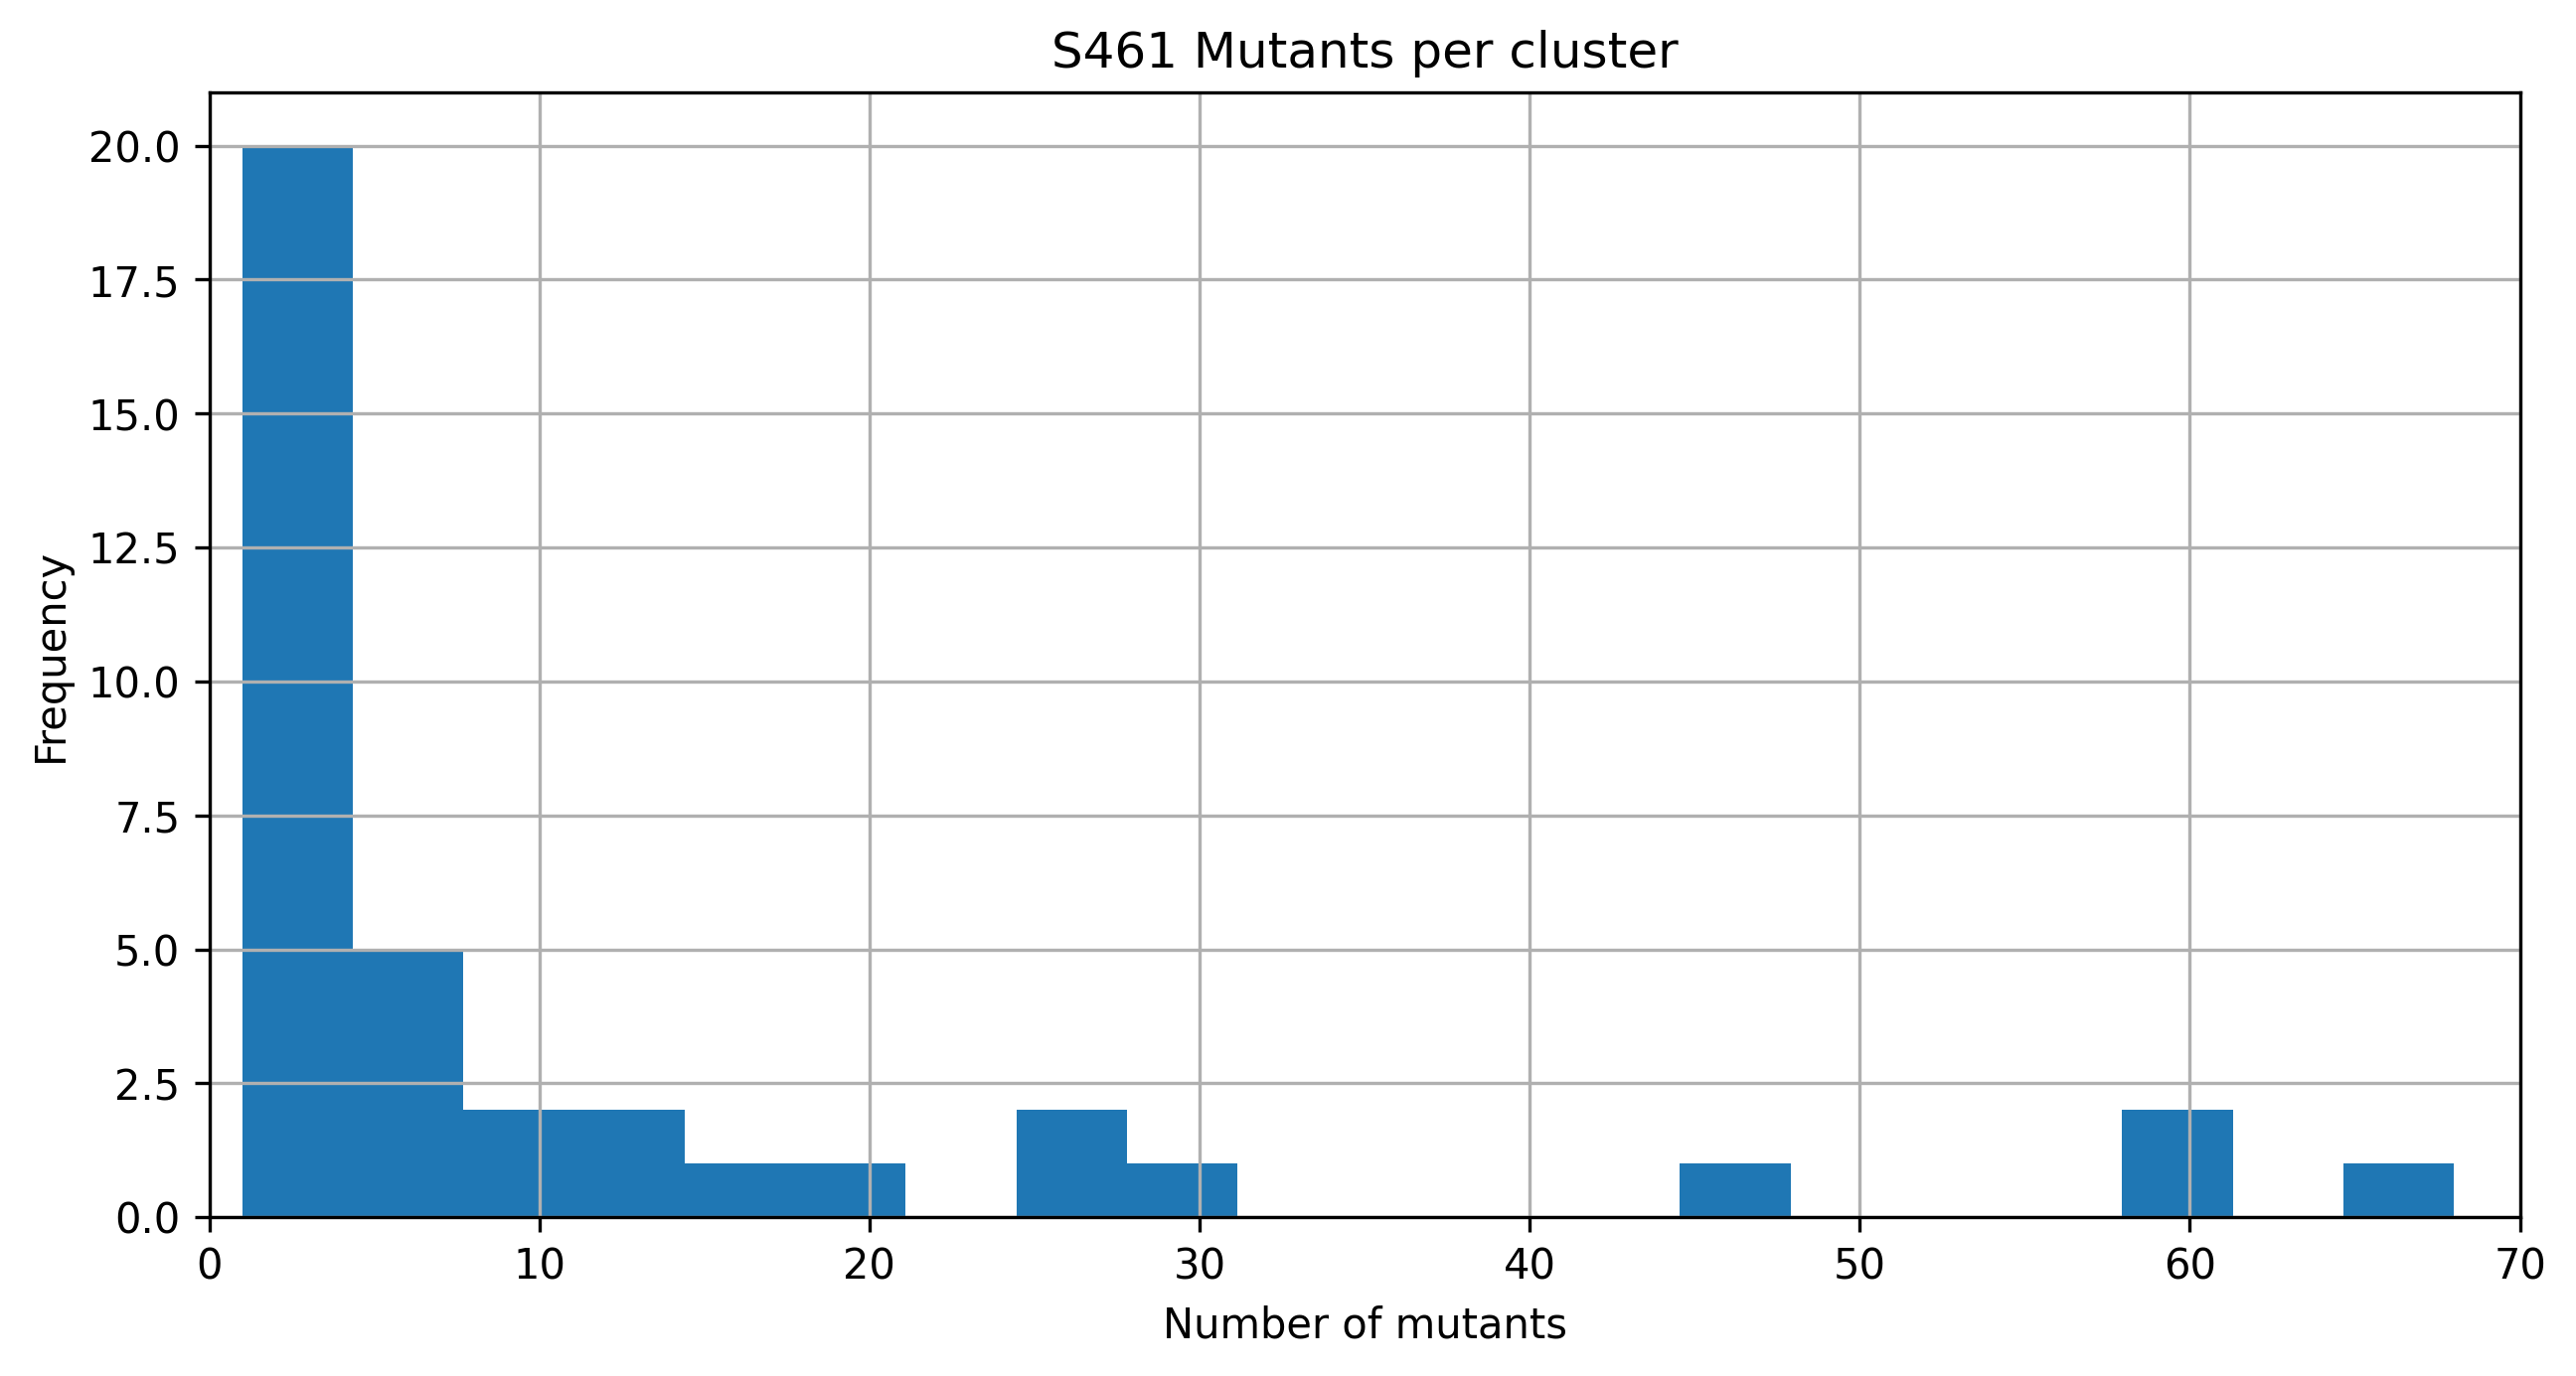

In [ ]:
db_class = db_preds.join(db_clusters).join(db_ddg).reset_index().set_index(['uid', 'uid2'])

db_class = db_class[original_pred_cols_reduced + ['ddG_dir', 'cluster']]

#db_class['ens_dir'] = db_class['mpnn_20_00_dir'] + db_class['cartesian_ddg_dir']

evolutionary = ['tranception', 'msa_transformer', 'esm1v', 'msa', 'esm2', 'ankh']
structural = ['mpnn', 'mif', 'esmif', 'mutcomputex']
supervised = ['MAESTRO', 'ThermoNet', 'INPS', 'PremPS', 'mCSM', 'DUET', 'ACDC', 'I-Mutant3.0', 'SAAFEC', 'MuPro']
untrained = ['DDGun']
potential = ['KORPM', 'PopMusic', 'SDM']
biophysical = ['cartesian_ddg', 'FoldX', 'Evo']

db_class_rescaled = db_class.copy(deep=True)
db_class_rescaled[original_pred_cols_reduced] /= db_class_rescaled[original_pred_cols_reduced].std()

db_class['structural_dir'] = db_class_rescaled[[c for c in db_class.columns if any([s in c for s in structural])]].mean(axis=1)
db_class['evolutionary_dir'] = db_class_rescaled[[c for c in db_class.columns if any([s in c for s in evolutionary])]].mean(axis=1)
db_class['supervised_dir'] = db_class[[c for c in db_class.columns if any([s in c for s in supervised])]].mean(axis=1)
db_class['potential_dir'] = db_class[[c for c in db_class.columns if any([s in c for s in potential])]].mean(axis=1)
db_class['biophysical_dir'] = db_class[[c for c in db_class.columns if any([s in c for s in biophysical])]].mean(axis=1)
db_class['mpnn_rosetta_dir'] = db_class['cartesian_ddg_dir'] + db_class['mpnn_20_00_dir']
db_class['mpnn_oracle_dir'] = db_class['stability-oracle_dir'] + db_class['mpnn_20_00_dir']

db_class['mpnn_mean_dir'] = db_class[['mpnn_10_00_dir', 'mpnn_20_00_dir', 'mpnn_30_00_dir']].mean(axis=1)
#db_class['runtime_mpnn_mean_dir'] = db_class[['runtime_mpnn_10_00_dir', 'runtime_mpnn_20_00_dir', 'runtime_mpnn_30_00_dir']].sum(axis=1)

db_class['esmif_mean_dir'] = db_class[['esmif_multimer_dir', 'esmif_monomer_dir']].mean(axis=1)
#db_class['runtime_esmif_mean_dir'] = db_class[['runtime_esmif_multimer_dir', 'runtime_esmif_monomer_dir']].sum(axis=1)

db_class['mif_mean_dir'] = db_class[['mif_dir', 'mifst_dir']].mean(axis=1)
#db_class['runtime_mif_mean_dir'] = db_class[['runtime_mif_dir', 'runtime_mifst_dir']].sum(axis=1)

db_class['esm2_mean_dir'] = db_class[['esm2_15B_half_dir', 'esm2_dir', 'esm2_650M_dir', 'esm2_150M_dir']].mean(axis=1)
#db_class['runtime_esm2_mean_dir'] = db_class[['runtime_esm2_15B_half_dir', 'runtime_esm2_dir', 'runtime_esm2_650M_dir', 'runtime_esm2_150M_dir']].sum(axis=1)

db_class['random_dir'] = np.random.rand(len(db_class)) - 0.5
db_class['random_inv'] = np.random.rand(len(db_class)) - 0.5

db_class = db_class.drop([c+'_dir' for c in ['ACDCNND', 'FoldXD', 'DDGunD', 'PopMsD', 'CartddgD', 'TNetD']], axis=1)
db_class['korpm_dir'] = db_class['KORPMD_dir']

db_class = db_class.join(db_feats_2[['delta_kdh', 'delta_vol', 'rel_ASA']])

print(f'Detected {len(db_class.loc[db_feats_2["on_interface"].astype(bool)])} interface mutations')

db_class.to_csv(preds_loc.replace('preds.csv', 'preds_clusters_extra.csv'))
fig, axes = plt.subplots(1, figsize=(10, 5), dpi=300) 
db_class.groupby('cluster').count().iloc[:, 0].hist(bins=20, ax=axes)
#db_class.groupby('cluster').count().iloc[:, 0].hist(bins=800, ax=axes[1])
plt.xlim([0,70])
plt.title('S461 Mutants per cluster')
plt.xlabel('Number of mutants')
plt.ylabel('Frequency')

db_class

In [ ]:
print((db_class.groupby('cluster').count().iloc[:, 0] >= 10).sum(), (db_class.groupby('cluster').count().iloc[:, 0] < 10).sum())

11 27


In [ ]:
db_class = pd.read_csv(preds_loc.replace('preds.csv', 'preds_clusters_extra.csv'))
db_class = db_class.set_index(['uid', 'uid2'])
db_class['ddG'] = db_class['ddG_dir']
db_class = db_class.rename(dict(zip([f'e{i}_transfer' for i in range(5)], [f'e{i}_transfer_dir' for i in range(5)])), axis=1)

In [ ]:
summ = analysis_utils.compute_stats(db_class.reset_index('uid2', drop=True), 
                                    stats=('n', 'MCC', 'pred_positives', 'tp', 'auprc', 'spearman', 'ndcg', 'mean_t1s', 'mean_stabilization', 'net_stabilization', 'sensitivity', 'recall@k0.0', 'recall@k1.0', 'mean_reciprocal_rank'), 
                                    measurements=['ddG'], grouper='cluster', n_classes=2, n_bootstraps=100, quiet=True)
tmp1 = summ.reset_index()

In [ ]:
remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'ndcg': 'NDCG', 
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = summ.sort_values('net_stabilization_mean', ascending=False).dropna(how='all', axis=1).reset_index()
s3 = s2.loc[s2['model'].isin(original_pred_cols_reduced + [
            'random_dir', 
            'ddG_dir', 
            'q3421_pslm_rfa_2_dir', 
            'q3421_pslm_rfa_3_dir', 
            'q3421_pslm_rfa_4_dir',
            'q3421_pslm_rfa_5_dir',
            'mpnn_rosetta_dir'])
            ].drop('measurement', axis=1)

s4 = s3[['model_type', 'model',
    'recall@k1.0_mean', 'recall@k1.0_std',
    'ndcg_mean', 'ndcg_std', 
    'spearman_mean', 'spearman_std',
    'auprc_mean', 'auprc_std', 
    'MCC_mean', 'MCC_std', 
    'net_stabilization_mean', 'net_stabilization_std',
    ]]
s4['model'] = s4['model'].map(lambda x: remap_names_2.get(x, x[:-4]))
s5 = s4.set_index(['model_type', 'model'])
s5.columns = [new_remap_cols[c] for c in s5.columns]
s5
# Iterate over the DataFrame and update the mean columns
for column in s5.columns:
    if 'mean' in column:
        stdev_column = column.replace('mean', 'stdev')
        s5[column] = s5[column].round(3).astype(str) + ' ± ' + s5[stdev_column].round(2).astype(str)

# Drop the standard deviation columns
s5 = s5[[col for col in s5.columns if 'stdev' not in col]]
s5.columns = [col[:-5] for col in s5.columns]
s6 = s5.reset_index().rename({'model_type': 'Model Type', 'model': 'Model'}, axis=1)
s6

,Model Type,Model,Recall @ k,NDCG,Spearman's ρ,AUPRC,MCC,Net Stabilization
0,unknown,ΔΔG label,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,78.183 ± 37.51
1,NaN,DDG_checked,0.854 ± 0.13,0.972 ± 0.04,0.967 ± 0.08,0.865 ± 0.13,0.909 ± 0.1,63.045 ± 52.27
2,evolutionary,ESM-2 15B,0.282 ± 0.12,0.659 ± 0.08,0.311 ± 0.12,0.356 ± 0.06,0.246 ± 0.07,7.414 ± 34.74
3,evolutionary,Tranception,0.124 ± 0.09,0.527 ± 0.09,0.248 ± 0.11,0.261 ± 0.06,0.189 ± 0.07,2.717 ± 11.82
4,biophysical,Rosetta CartDDG,0.241 ± 0.12,0.746 ± 0.1,0.601 ± 0.1,0.483 ± 0.07,0.31 ± 0.07,-2.836 ± 32.64
5,evolutionary,MSA-T median,0.209 ± 0.1,0.591 ± 0.09,0.207 ± 0.1,0.275 ± 0.05,0.146 ± 0.05,-4.401 ± 16.37
6,evolutionary,MSA-T mean,0.209 ± 0.1,0.583 ± 0.08,0.213 ± 0.1,0.278 ± 0.05,0.136 ± 0.05,-12.297 ± 16.8
7,evolutionary,ESM-2 650M,0.295 ± 0.11,0.625 ± 0.08,0.418 ± 0.12,0.341 ± 0.04,0.234 ± 0.05,-12.405 ± 36.9
8,supervised,MuPro,0.095 ± 0.07,0.501 ± 0.06,0.322 ± 0.14,0.268 ± 0.04,0.05 ± 0.06,-15.6 ± 13.18
9,structural,MIF-ST,0.243 ± 0.11,0.632 ± 0.09,0.386 ± 0.13,0.357 ± 0.06,0.266 ± 0.06,-15.707 ± 43.6


stability-oracle
cartesian_ddg
KORPMD
mpnn_20_00
esm2_650M
random


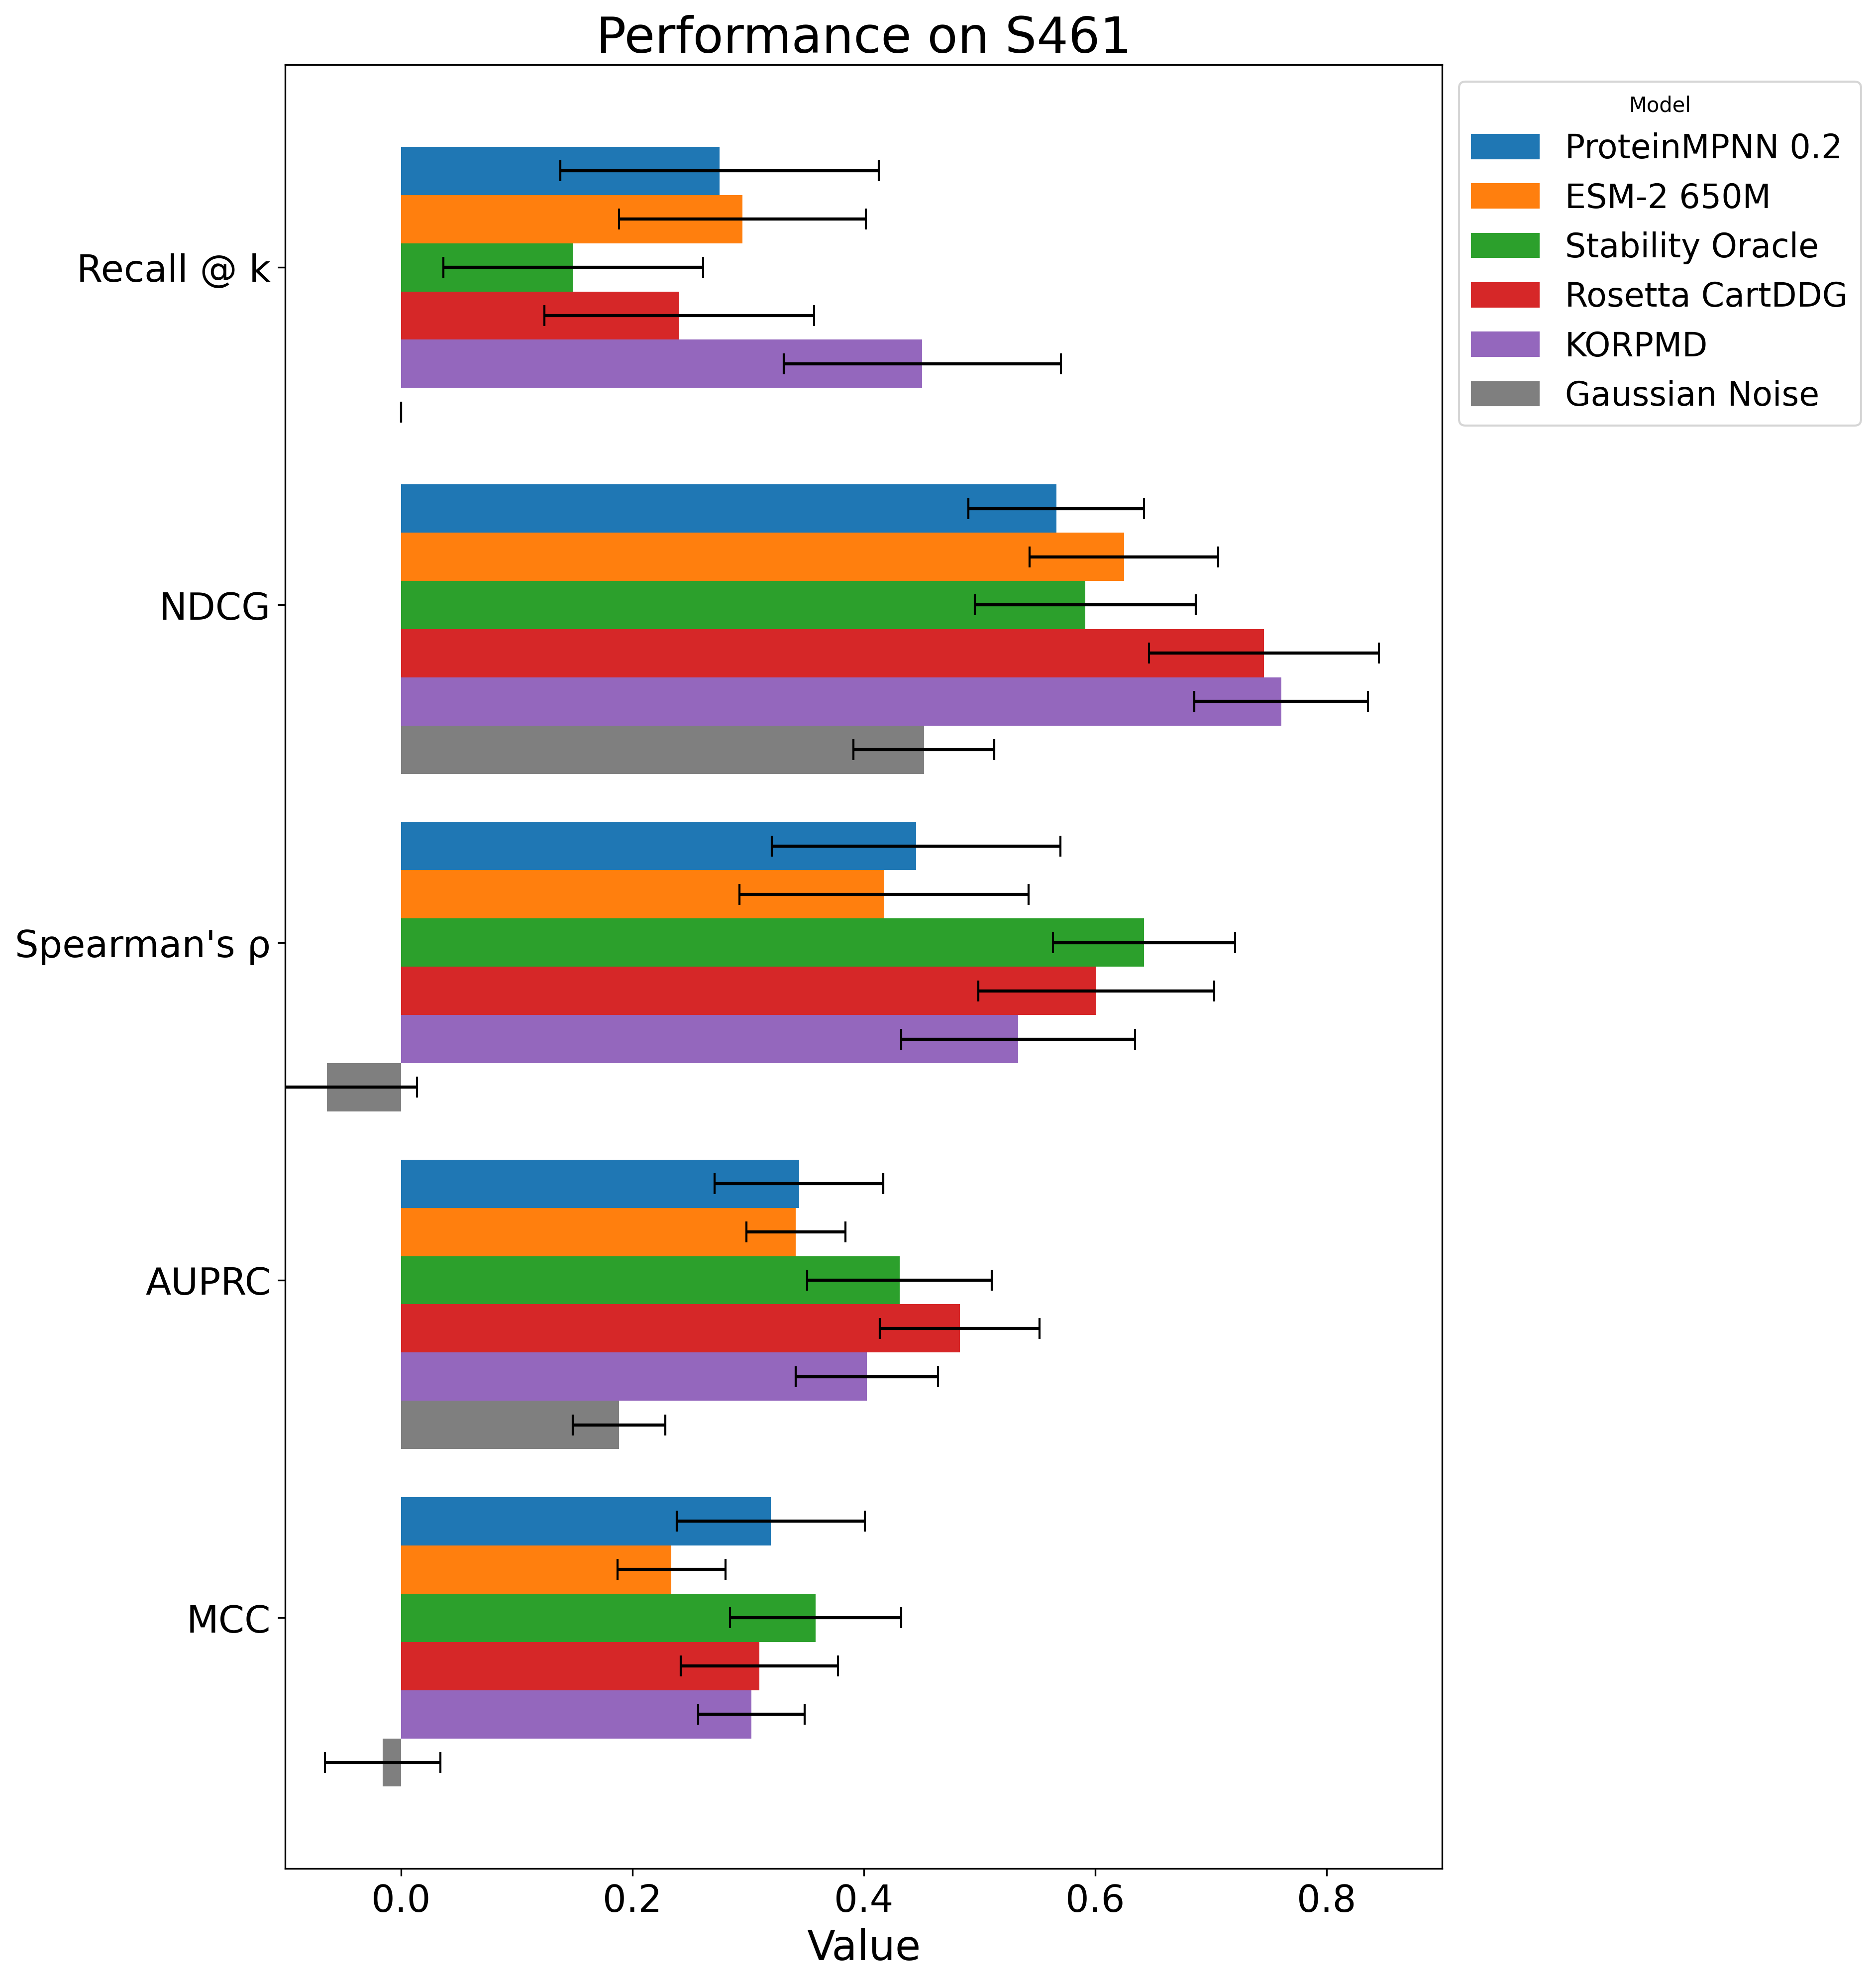

In [ ]:
import importlib
importlib.reload(analysis_utils)

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

tmp3 = tmp1.copy(deep=True)#.set_index('model')
#tmp3['fractional_gain_mean'] = tmp3['net_stabilization_mean'] / tmp3.at['ddG_dir', 'net_stabilization_mean']
#tmp3['fractional_gain_std'] = tmp3['net_stabilization_std'] / tmp3.at['ddG_dir', 'net_stabilization_mean']
#tmp3 = tmp3.reset_index()
#tmp3['fractional_gain_mean']

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'ndcg': 'NDCG',
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = tmp3.sort_values('spearman_mean', ascending=False).dropna(how='all', axis=1).reset_index()
s4 = s2.loc[s2['model'].isin(original_pred_cols_reduced + ['random_dir', 'ddG_dir', 'mpnn_rosetta_dir'])]
#s4 = s3[['model', 'n_mean', 'MCC_mean', 'MCC_std', 'auprc_mean', 'auprc_std', 'spearman_mean', 'spearman_std', 'weighted_ndcg_mean', 'weighted_ndcg_std', 'recall@k1.0_mean', 'recall@k1.0_std', 'mean_stabilization_mean', 'mean_stabilization_std']]
#s4['model'] = s4['model'].map(lambda x: remap_names_2.get(x, x[:-4]))
s5 = s4

tmp2 = s5[[ 'model',  
            'MCC_mean', 'MCC_std',
            'auprc_mean', 'auprc_std',
            #'weighted_spearman_mean', 'weighted_spearman_std',
            'spearman_mean', 'spearman_std',
            #'weighted_ndcg_mean', 'weighted_ndcg_std',
            'ndcg_mean', 'ndcg_std',
            'recall@k1.0_mean', 'recall@k1.0_std', 
            ]].set_index('model')

tmp2.columns = [new_remap_cols[c] for c in tmp2.columns]
tmp2 = tmp2.reset_index().drop_duplicates()

#analysis_utils.make_bar_chart(tmp2, models=['ProteinMPNN 0.2', 'ESM-2 650M', 'Stability Oracle', 'Rosetta CartDDG', 'KORPM', 'DDGun3D', 'MAESTRO', 'Gaussian Noise'], title='Q3421', xlim=(-0.5, 0.8), figsize=(24, 16))
analysis_utils.make_bar_chart(tmp2, models=['mpnn_20_00', 'esm2_650M', 'stability-oracle', 'cartesian_ddg', 'KORPMD', 'random'], title='S461', xlim=(-0.1, 0.9), figsize=(10, 16))

In [ ]:
tmp2

,model,MCC mean,MCC stdev,AUPRC mean,AUPRC stdev,Spearman's ρ mean,Spearman's ρ stdev,NDCG mean,NDCG stdev,Recall @ k mean,Recall @ k stdev
0,ddG,1.000000,0.000000,1.000000,1.324958e-16,1.000000,1.046728e-16,1.000000,1.863780e-16,1.000000,0.000000
1,DDG_checked,0.909166,0.095904,0.864617,1.282624e-01,0.967238,8.237929e-02,0.971759,4.444290e-02,0.853952,0.133539
2,stability-oracle,0.358494,0.074017,0.430928,7.979834e-02,0.642187,7.855485e-02,0.591626,9.540754e-02,0.149036,0.112272
3,mpnn_rosetta,0.327298,0.072744,0.500494,7.613477e-02,0.626827,9.469097e-02,0.755738,1.060013e-01,0.289480,0.113737
4,cartesian_ddg,0.309843,0.067890,0.483053,6.901007e-02,0.600813,1.019599e-01,0.745951,9.932195e-02,0.240591,0.116446
5,PopMusic,0.268406,0.034150,0.373358,3.942280e-02,0.582201,8.631111e-02,0.529018,5.786521e-02,0.102143,0.090909
6,MAESTRO,0.308555,0.040537,0.352907,5.093674e-02,0.576778,8.394325e-02,0.514981,5.410403e-02,0.000000,0.000000
7,INPS3D,0.209299,0.052883,0.350767,6.952649e-02,0.575603,9.781214e-02,0.526950,7.866684e-02,0.095119,0.074197
8,PremPS,0.181026,0.088210,0.338890,4.433640e-02,0.572541,1.161365e-01,0.716483,1.117378e-01,0.243218,0.134625
9,DDGun3D,0.305135,0.066788,0.367029,5.775832e-02,0.547339,1.231582e-01,0.715570,1.100027e-01,0.187218,0.113819


In [ ]:
# our Rosetta predictions are not that stronly correlated to Hernandez et. al, although ours tend to perform better
print(db_preds[['CartddgD_dir', 'cartesian_ddg_dir']].corr().iloc[1,0])

0.7745444496523972


In [ ]:
zs_feats = ['delta_kdh', 'delta_vol', 'rel_ASA']

db_ens = db_class.copy(deep=True).reset_index().set_index('uid2').reset_index(drop=True).set_index('uid') #.join(db_feats_2.drop(['SOL_ACC_dir', 'SOL_ACC_inv'], axis=1))
#db_ens = db_ens.rename({'ddG_dir': 'ddG'}, axis=1) 
#models = original_pred_cols_reduced + [c + '_dir' for c in zs_feats]
models = list(db_class.columns) + [z+'_dir' for z in zs_feats]
models.remove('ddG_dir')
#models.remove('ddG_dir')

for zs in zs_feats:
    db_ens[zs+'_dir'] = db_ens[zs]

print(len(db_ens))
db_ens['random_dir'] = np.random.normal(size=len(db_ens)) - 0.5
#db_ens['random_inv'] = np.random.normal(size=len(db_ens)) - 0.5
#db_ens = db_ens.drop(['KORPMD_dir', 'CartddgD_dir', 'FoldXD_dir', 'EvoD_dir', 'Dyna2D_dir', 'PopMsD_dir', 'DDGunD_dir', 'TNetD_dir', 'ACDCNND_dir'], axis=1)
dfm = db_ens.copy(deep=True)
models

461


['KORPMD_dir',
 'EvoD_dir',
 'Dyna2D_dir',
 'ACDC-NN-Seq_dir',
 'ACDC-NN_dir',
 'DDG_checked_dir',
 'DDGun3D_dir',
 'DDGun_dir',
 'DUET_dir',
 'Dynamut_dir',
 'FoldX_dir',
 'I-Mutant3.0-Seq_dir',
 'I-Mutant3.0_dir',
 'INPS-Seq_dir',
 'INPS3D_dir',
 'MAESTRO_dir',
 'MuPro_dir',
 'PopMusic_dir',
 'PremPS_dir',
 'SAAFEC-Seq_dir',
 'SDM_dir',
 'ThermoNet_dir',
 'esmif_monomer_dir',
 'mCSM_dir',
 'mpnn_10_00_dir',
 'mpnn_20_00_dir',
 'mpnn_30_00_dir',
 'esmif_multimer_dir',
 'esm2_dir',
 'esm2_15B_half_dir',
 'msa_transformer_median_dir',
 'msa_transformer_mean_dir',
 'tranception_dir',
 'esm2_150M_dir',
 'esm2_650M_dir',
 'esm1v_median_dir',
 'esm1v_mean_dir',
 'ankh_dir',
 'mif_dir',
 'mifst_dir',
 'korpm_dir',
 'mutcomputex_dir',
 'stability-oracle_dir',
 'cartesian_ddg_dir',
 'cluster',
 'structural_dir',
 'evolutionary_dir',
 'supervised_dir',
 'potential_dir',
 'biophysical_dir',
 'mpnn_rosetta_dir',
 'mpnn_oracle_dir',
 'mpnn_mean_dir',
 'esmif_mean_dir',
 'mif_mean_dir',
 'esm2_mean

In [ ]:
weights = [1, 0.5, 0.2]
#weights2 = [0.8, 0.3]

all_cols = []

tmp = []
for model1 in models:
    for model2 in models:
        if model1[-4:] == model2[-4:] and model1 != model2: #(model1.split('_')[0] != model2.split('_')[0]) and (model1[:4] != model2[:4]) and
            for weight in weights:
                tmp.append(pd.Series(dfm[model1]/dfm[model1].std() + dfm[model2]/dfm[model2].std() * weight, name=f'{model1} + {model2} * {weight}'))
                all_cols.append(f'{model1} + {model2} * {weight}')
                #for model3 in models:
                #    if model2 != model3 and model1 != model3:
                #        for weight2 in weights2:
                #            tmp.append(pd.Series(dfm[model1] + dfm[model2] * weight + dfm[model3] * weight2, name=f'{model1} + {model2} * {weight} + {model3} * {weight2}'))
                #            all_cols.append(f'{model1} + {model2} * {weight} + {model3} * {weight2}')

dfm = pd.concat([dfm] + tmp, axis=1)
dfm = dfm.join(db_runtimes)
#dfm.to_csv(os.path.join(path, 'results', 'ensemble_s461_2_models_3_weights_preds.csv'))
dfm.columns

Index(['KORPMD_dir', 'EvoD_dir', 'Dyna2D_dir', 'ACDC-NN-Seq_dir',
       'ACDC-NN_dir', 'DDG_checked_dir', 'DDGun3D_dir', 'DDGun_dir',
       'DUET_dir', 'Dynamut_dir',
       ...
       'runtime_esm1v_3_dir', 'runtime_esm1v_4_dir', 'runtime_esm1v_5_dir',
       'runtime_esm1v_median_dir', 'runtime_esm1v_mean_dir',
       'runtime_ankh_dir', 'runtime_mif_dir', 'runtime_mifst_dir',
       'runtime_cartesian_ddg_dir', 'runtime_korpm'],
      dtype='object', length=10361)

In [ ]:
def get_summary_df(db_complete, cols=None, saveloc=os.path.join(path, 'results', 'ensemble_s461_2_models_3_weights_results.csv'), stats=(), stacked=False):

    assert os.path.exists(os.path.dirname(saveloc))
    assert not os.path.exists(saveloc)
    #if cols is None:
    #    cols = db_complete.columns.drop(['code'])#, 'ddG_dir', 'ddG_inv'])

    #if not stacked:
    #    db_stacked = stack_frames(db_complete)
    #else:
    #    db_stacked = db_complete
    #db_stacked['code'] = list(db_stacked.reset_index()['uid'].str[:4])

    df_summ = analysis_utils.compute_stats(db_complete, stats=(), grouper='cluster', measurements=['ddG']).reset_index().set_index(['measurement', 'model'])#.join(df_reg) #.drop('n_total', axis=1))
    df_summ = df_summ.reset_index().rename({'index': 'model'}, axis=1).set_index(['measurement', 'model_type', 'model', 'class'])
    df_summ = df_summ.sort_index(level=1).sort_index(level=0)#.drop_duplicates()
    df_summ.to_csv(saveloc)
    return df_summ

In [ ]:
import importlib
importlib.reload(analysis_utils)
# takes a long time to compute and has already been done
#d1 = get_summary_df(dfm, saveloc=os.path.join(path, 'data', 'ensemble_s461_2_models_3_weights_revisions_runtimes.csv'), stats=()) 

d1 = pd.read_csv(os.path.join(path, 'data', 'ensemble_s461_2_models_3_weights_revisions_runtimes.csv')).set_index(['measurement', 'model_type', 'model', 'class'])

FileNotFoundError: [Errno 2] No such file or directory: '../data/ensemble_s461_2_models_3_weights_revisions_runtimes.csv'

['ACDC-NN_dir', 'DDGun3D_dir', 'DUET_dir', 'Dynamut_dir', 'FoldX_dir', 'EvoD_dir', 'I-Mutant3.0_dir', 'INPS3D_dir', 'MAESTRO_dir', 'MUpro_dir', 'PopMusic_dir', 'PremPS_dir', 'ThermoNet_dir', 'SAAFEC-Seq_dir', 'SDM_dir', 'mCSM_dir', 'cartesian_ddg_dir', 'esm1v_mean_dir', 'ankh_dir', 'msa_transformer_mean_dir', 'tranception_dir', 'esm2_dir', 'esmif_multimer_dir', 'KORPMD_dir', 'mpnn_20_00_dir', 'mif_dir', 'mifst_dir', 'stability-oracle_dir', 'mutcomputex_dir']
461
0.14890636102584937
Text(0.5, 0, 'stability-oracle_dir')
Text(1.5, 0, 'cartesian_ddg_dir')
Text(2.5, 0, 'PremPS_dir')
Text(3.5, 0, 'PopMusic_dir')
Text(4.5, 0, 'MAESTRO_dir')
Text(5.5, 0, 'INPS3D_dir')
Text(6.5, 0, 'DDGun3D_dir')
Text(7.5, 0, 'DUET_dir')
Text(8.5, 0, 'ACDC-NN_dir')
Text(9.5, 0, 'KORPMD_dir')
Text(10.5, 0, 'mCSM_dir')
Text(11.5, 0, 'SDM_dir')
Text(12.5, 0, 'ThermoNet_dir')
Text(13.5, 0, 'SAAFEC-Seq_dir')
Text(14.5, 0, 'I-Mutant3.0_dir')
Text(15.5, 0, 'EvoD_dir')
Text(16.5, 0, 'mif_dir')
Text(17.5, 0, 'ankh_dir')

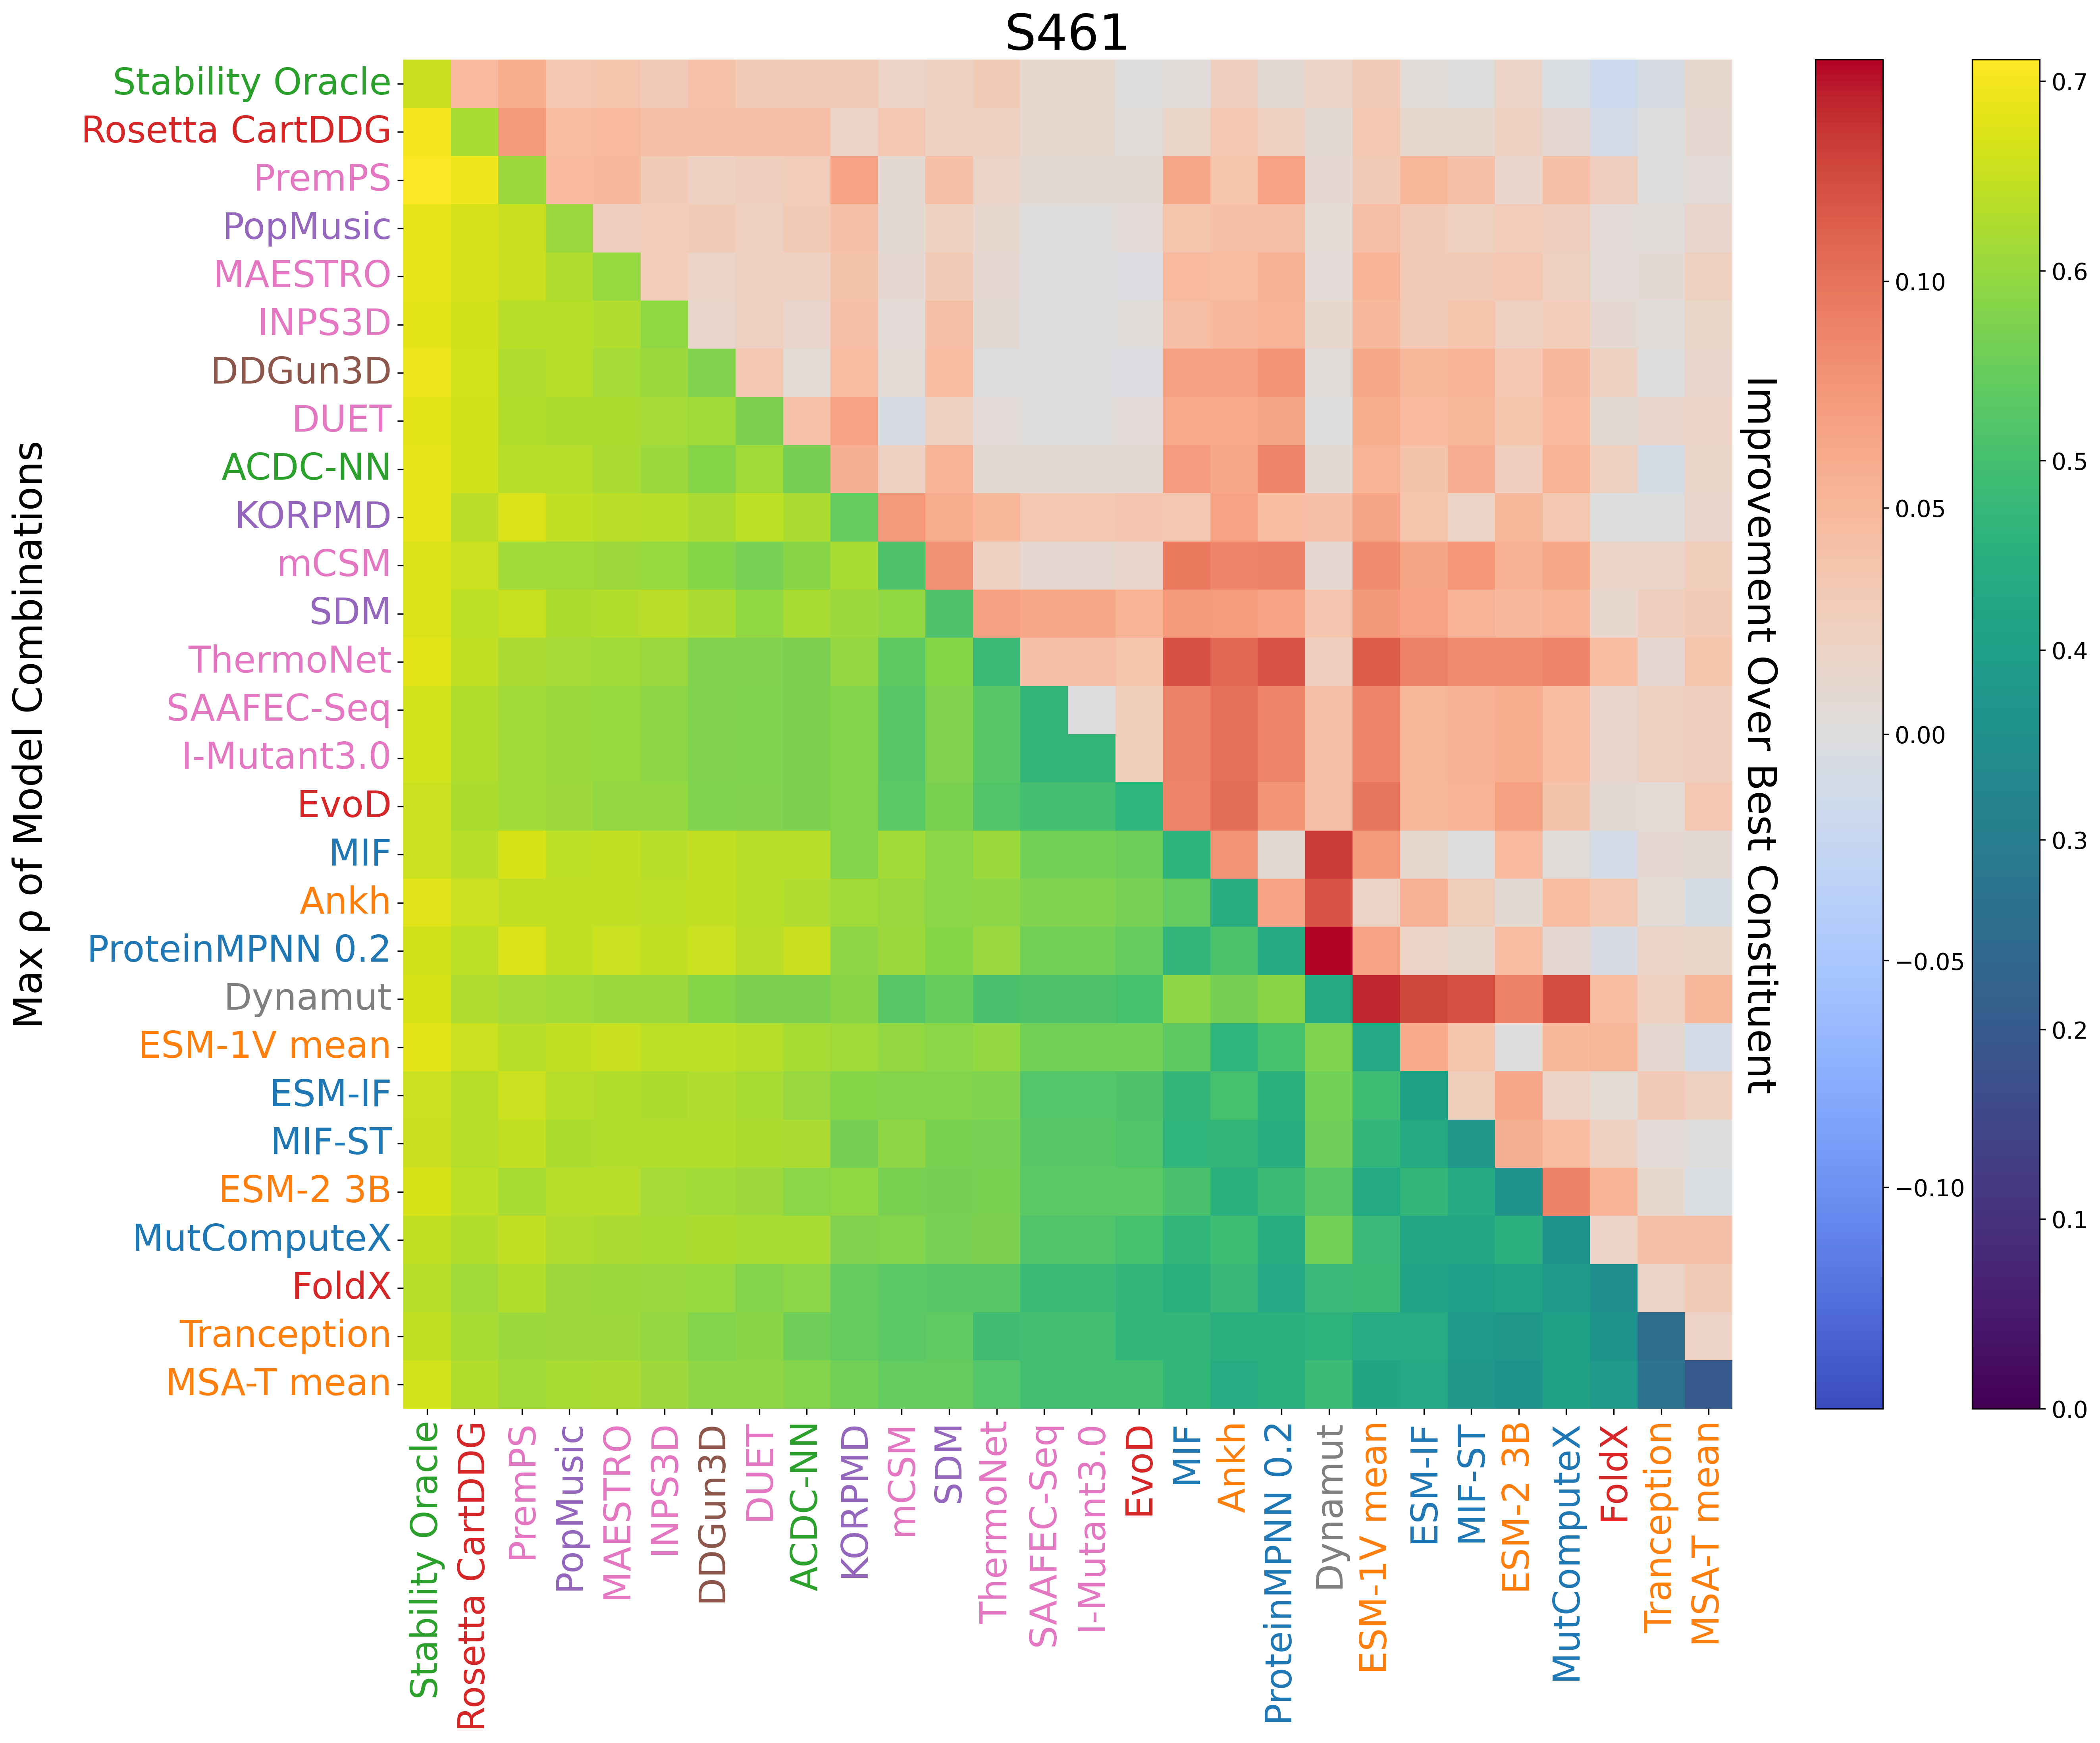

{'mCSM', 'ESM-1V mean', 'PopMusic', 'ESM-2 3B', 'DDGun3D', 'MAESTRO', 'Rosetta CartDDG', 'ProteinMPNN 0.2', 'ACDC-NN', 'MIF', 'PremPS', 'ESM-IF', 'Ankh', 'Dynamut', 'SDM', 'KORPMD', 'ThermoNet', 'DUET', 'MSA-T mean', 'INPS3D', 'Stability Oracle', 'I-Mutant3.0'}


,model1,weight1,model2,weight2,spearman,corr,runtime_cpu,runtime_gpu
rank,,,,,,,,
1,Stability Oracle,1.0,PremPS,0.5,0.711284,0.550506,-0.0001,-0.000100
2,Stability Oracle,1.0,Rosetta CartDDG,0.5,0.697886,0.635180,368117.9999,-0.000100
3,PremPS,1.0,Rosetta CartDDG,1.0,0.693728,0.530449,368117.9999,-0.000100
4,Stability Oracle,1.0,DDGun3D,0.5,0.691471,0.602141,-0.0001,-0.000100
5,Stability Oracle,1.0,MAESTRO,0.5,0.688428,0.638792,-0.0001,-0.000100
...,...,...,...,...,...,...,...,...
374,ESM-2 3B,1.0,MSA-T mean,0.2,0.359221,0.627177,-0.0001,4218.066468
375,FoldX,1.0,FoldX,0.0,0.351706,1.000000,-0.0001,-0.000100
376,Tranception,1.0,MSA-T mean,0.5,0.271344,0.351386,-0.0001,10151.365200


In [ ]:
import importlib
importlib.reload(analysis_utils)

custom_colors = {#'ACDC-NN-Seq_dir': 'blue', 
                 'ACDC-NN_dir': 'purple',
                 #'DDGun_dir': 'blue',
                 'DDGun3D_dir': 'purple',
                 'DUET_dir': 'purple',
                 'Dynamut_dir': 'orange',
                 'FoldX_dir': 'red',
                 'EvoD_dir': 'green',
                 'I-Mutant3.0_dir': 'orange',
                 #'I-Mutant3.0-Seq_dir': 'green',
                 #'INPS-Seq_dir': 'blue',
                 'INPS3D_dir': 'purple',
                 'MAESTRO_dir': 'purple',
                 'MUpro_dir': 'red',
                 'PopMusic_dir': 'red',
                 'PremPS_dir': 'purple',
                 'ThermoNet_dir': 'purple',
                 'SAAFEC-Seq_dir': 'orange',
                 'SDM_dir': 'purple',
                 #'SOL_ACC_dir': 'red',
                 #'delta_kdh': 'blue',
                 #'delta_vol': 'blue',
                 #'abs_ASA': 'red',
                 'ThermoNet_dir': 'red',
                 'mCSM_dir': 'red',
                 'cartesian_ddg_dir': 'red',
                 'esm1v_mean_dir': 'blue',
                 #'esm2_mean_dir': 'blue',
                 'ankh_dir': 'blue',
                 'msa_transformer_mean_dir': 'blue',
                 'tranception_dir': 'blue',
                 'esm2_dir': 'blue',
                 #'esmif_monomer': 'red',
                 'esmif_multimer_dir': 'red',
                 'KORPMD_dir': 'red',
                 'mpnn_20_00_dir': 'red',
                 'mif_dir': 'red',
                 'mifst_dir': 'purple',
                 #'mpnn_mean_dir': 'red',
                 #'esmif_mean_dir': 'red',
                 #'mif_mean_dir': 'red',
                 'stability-oracle_dir': 'orange',
                 'mutcomputex_dir': 'orange'
                 }

subset = list(custom_colors.keys())
print(subset)

#custom_colors = dict(zip([key+'_dir' for key in custom_colors.keys()], list(custom_colors.values())))
#print(custom_colors)

measurement = 'ddG'
statistic = 'spearman'

db_ddg_ = db_ddg.copy(deep=True)
db_ddg_ = db_ddg_.rename({'ddG_dir': 'ddG'}, axis=1).reset_index('uid2', drop=True)
d3 = d1.copy(deep=True)

#dfm['code'] = dfm.index.str[:4]

stat_df_, delta_df = analysis_utils.model_combinations_heatmap(d3, dfm.fillna(0), db_ddg_, statistic, measurement, threshold=0, subset=subset, n_bootstraps=0, grouper=None, upper='delta', annot=False, title='S461')
#stat_df = analysis_utils.model_combinations_heatmap_2(d2, dfm, statistic, direction, upper, threshold=None, custom_colors=custom_colors)
stat_df = stat_df_
stat_df = stat_df.drop_duplicates(subset=[f'{statistic}', 'runtime_cpu', 'runtime_gpu']).reset_index(drop=True).sort_values(f'{statistic}', ascending=False).reset_index(drop=True).reset_index()
stat_df['model1'] = stat_df['model1'].map(lambda x: remap_names_2.get(x, x[:-4]))
stat_df['model2'] = stat_df['model2'].map(lambda x: remap_names_2.get(x, x[:-4]))

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models_ = set(list(out['model1']) + list(out['model2']))
print(models_)
stat_df

In [ ]:
stat_df_ = stat_df.applymap(lambda x: np.nan if x==-0.0001 else x)
stat_df_ = stat_df.applymap(lambda x: round(x, 2) if type(x)==float else x)
for source, target in remap_names.items():
    stat_df_.loc[stat_df_['model1']==source, 'model1'] = target
    stat_df_.loc[stat_df_['model2']==source, 'model2'] = target
stat_df_ = stat_df_.reset_index().drop('weight1', axis=1).rename({'rank': 'Rank', 'model1': 'Base model', 'model2': 'Added Model', 'weight2': 'Weight', 'corr': 'Model Correlation', 'runtime_cpu': 'CPU time (s)', 'runtime_gpu': 'GPU time (s)', 'spearman': 'Spearman\'s rho'}, axis=1)
#stat_df_.to_csv('../data/stat_df_s461.csv')
stat_df_

,Rank,Base model,Added Model,Weight,Spearman's rho,Model Correlation,CPU time (s),GPU time (s)
0,1,Stability Oracle,PremPS,0.5,0.71,0.55,-0.0,-0.00
1,2,Stability Oracle,Rosetta CartDDG,0.5,0.70,0.64,368118.0,-0.00
2,3,PremPS,Rosetta CartDDG,1.0,0.69,0.53,368118.0,-0.00
3,4,Stability Oracle,DDGun3D,0.5,0.69,0.60,-0.0,-0.00
4,5,Stability Oracle,MAESTRO,0.5,0.69,0.64,-0.0,-0.00
...,...,...,...,...,...,...,...,...
373,374,ESM-2 3B,MSA-T mean,0.2,0.36,0.63,-0.0,4218.07
374,375,FoldX,FoldX,0.0,0.35,1.00,-0.0,-0.00
375,376,Tranception,MSA-T mean,0.5,0.27,0.35,-0.0,10151.37
376,377,Tranception,Tranception,0.0,0.25,1.00,-0.0,6012.66


['ACDC-NN_dir', 'DDGun3D_dir', 'DUET_dir', 'Dynamut_dir', 'FoldX_dir', 'EvoD_dir', 'I-Mutant3.0_dir', 'INPS3D_dir', 'MAESTRO_dir', 'MUpro_dir', 'PopMusic_dir', 'PremPS_dir', 'ThermoNet_dir', 'SAAFEC-Seq_dir', 'SDM_dir', 'mCSM_dir', 'cartesian_ddg_dir', 'esm1v_mean_dir', 'ankh_dir', 'msa_transformer_mean_dir', 'tranception_dir', 'esm2_dir', 'esmif_multimer_dir', 'KORPMD_dir', 'mpnn_20_00_dir', 'mif_dir', 'mifst_dir', 'stability-oracle_dir', 'mutcomputex_dir']
461
42.424
Text(0.5, 0, 'tranception_dir')
Text(1.5, 0, 'cartesian_ddg_dir')
Text(2.5, 0, 'msa_transformer_mean_dir')
Text(3.5, 0, 'esm1v_mean_dir')
Text(4.5, 0, 'PremPS_dir')
Text(5.5, 0, 'mifst_dir')
Text(6.5, 0, 'ankh_dir')
Text(7.5, 0, 'SAAFEC-Seq_dir')
Text(8.5, 0, 'I-Mutant3.0_dir')
Text(9.5, 0, 'INPS3D_dir')
Text(10.5, 0, 'esm2_dir')
Text(11.5, 0, 'PopMusic_dir')
Text(12.5, 0, 'esmif_multimer_dir')
Text(13.5, 0, 'mCSM_dir')
Text(14.5, 0, 'stability-oracle_dir')
Text(15.5, 0, 'DUET_dir')
Text(16.5, 0, 'mif_dir')
Text(17.5, 0,

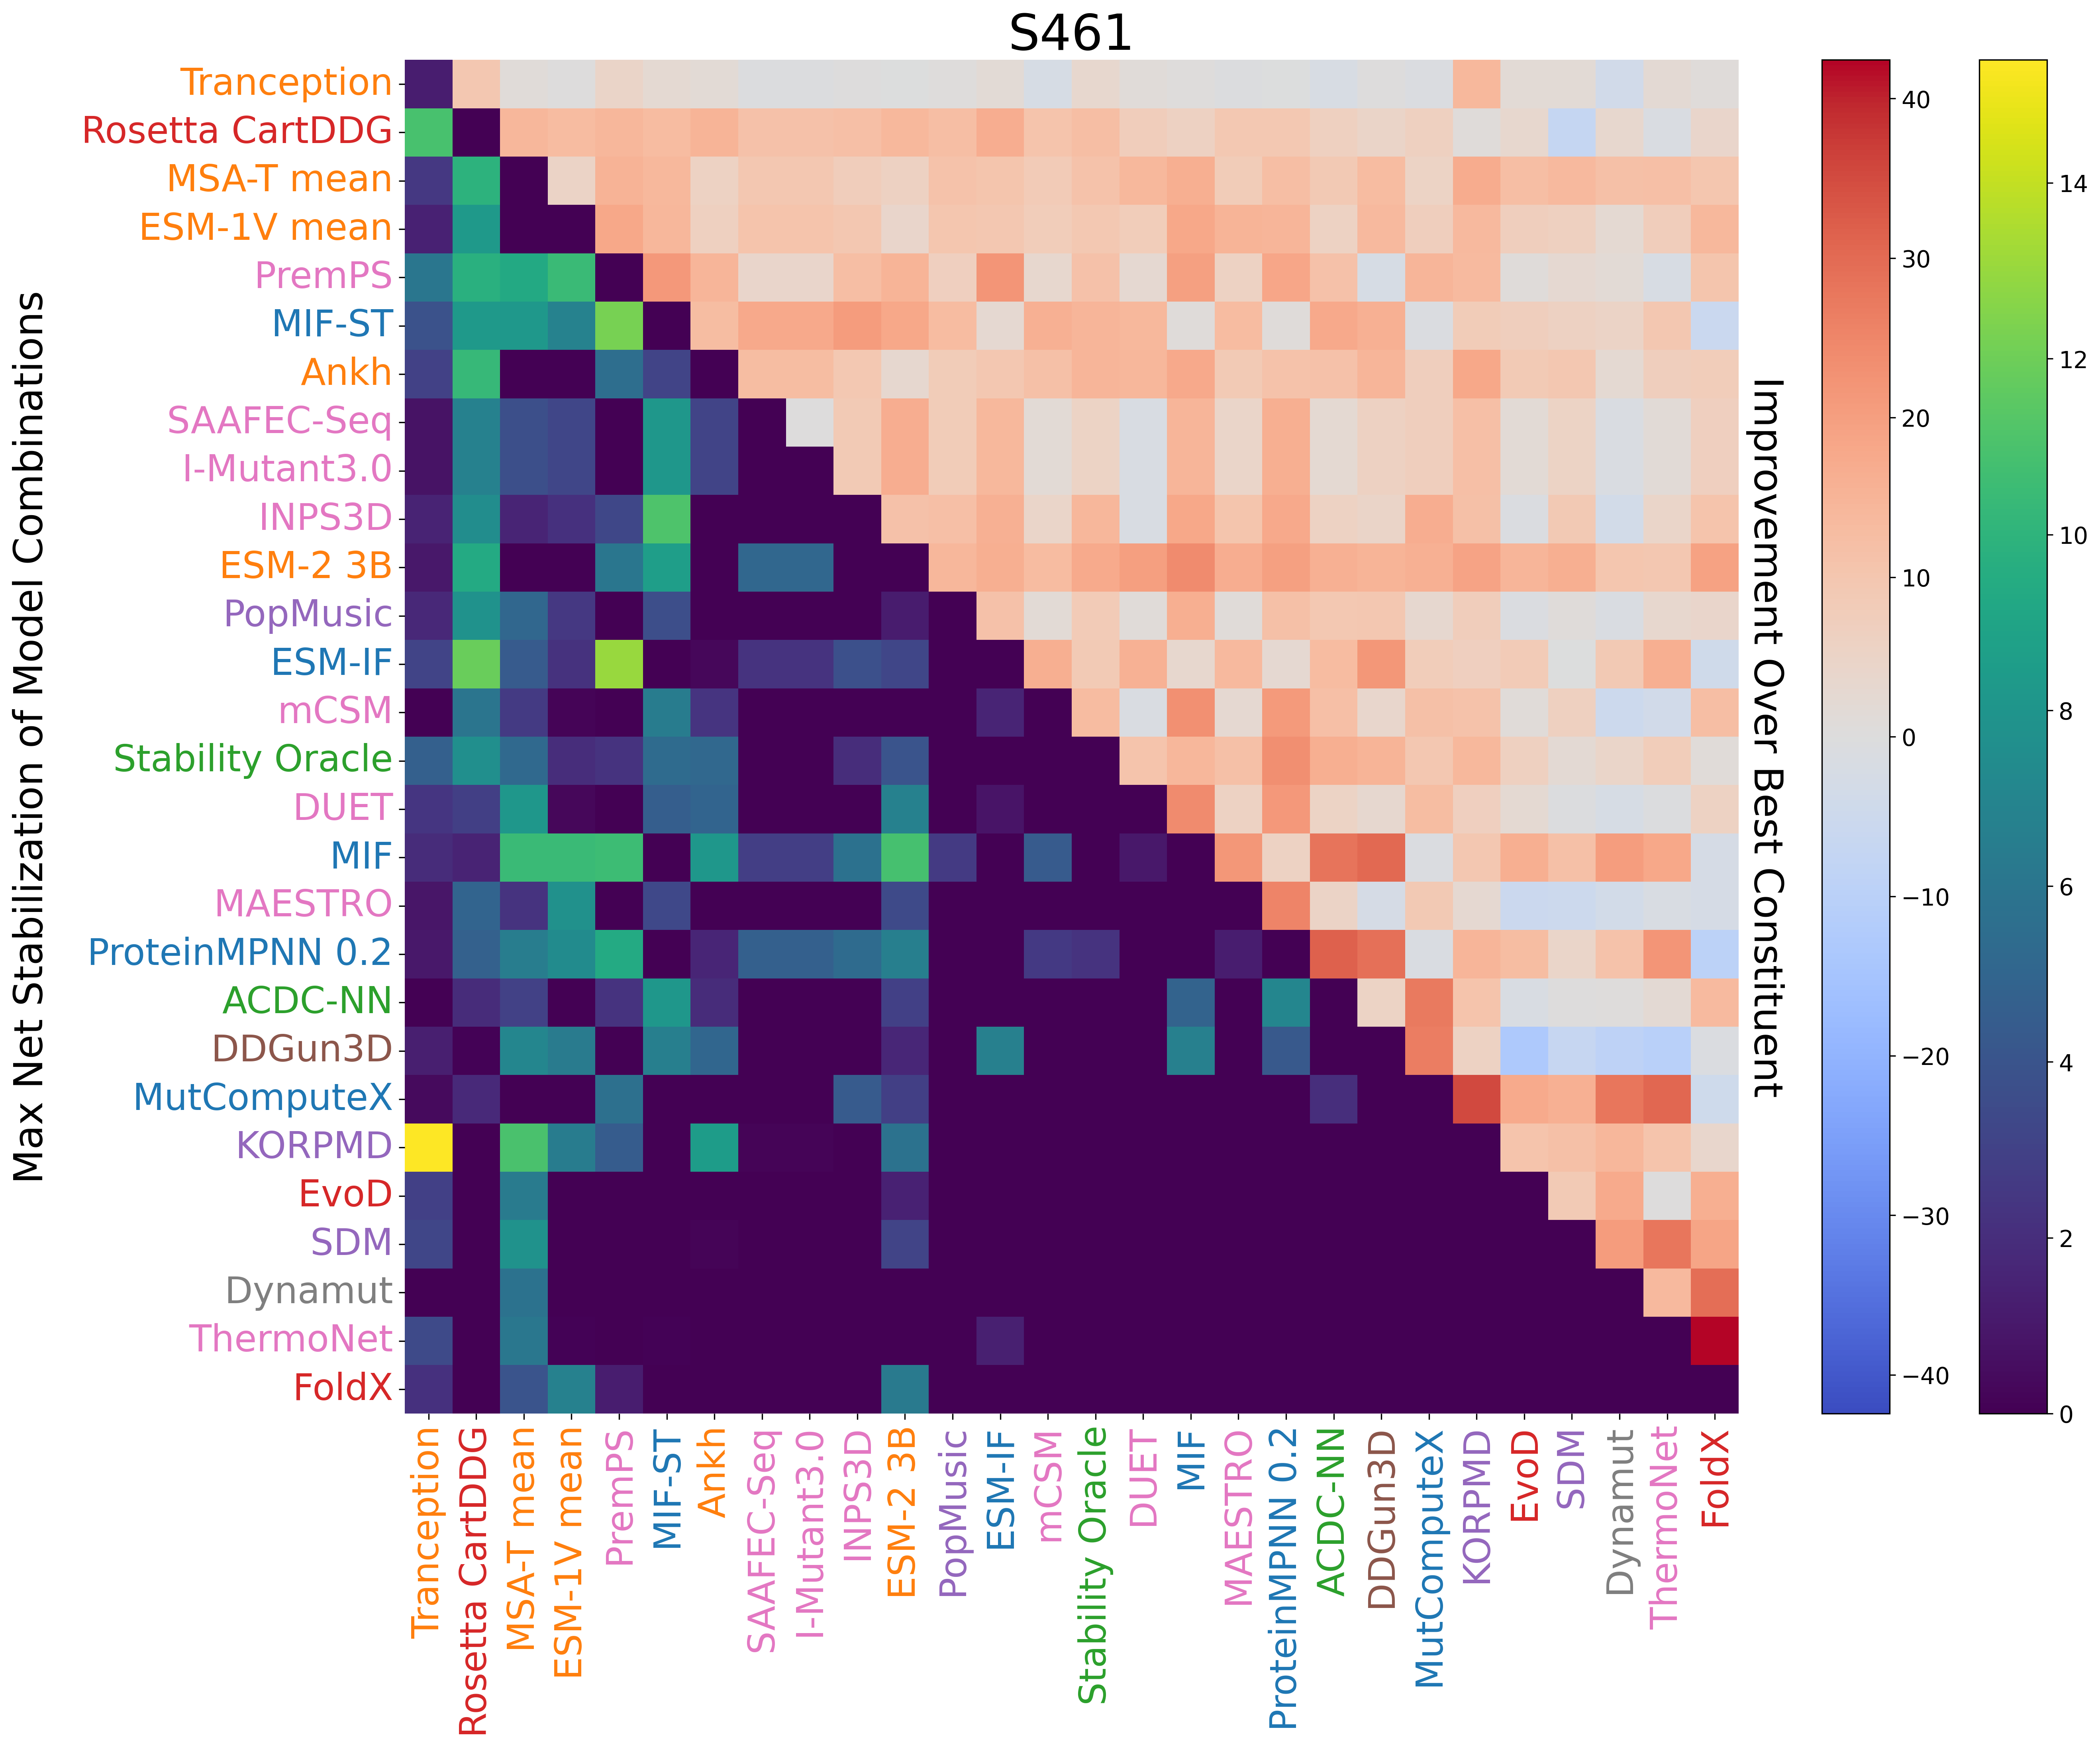

{'Tranception', 'ESM-1V mean', 'PopMusic', 'ESM-2 3B', 'MAESTRO', 'Rosetta CartDDG', 'ProteinMPNN 0.2', 'MIF', 'ACDC-NN', 'MIF-ST', 'PremPS', 'ESM-IF', 'Ankh', 'SDM', 'KORPMD', 'DUET', 'MSA-T mean', 'INPS3D', 'I-Mutant3.0'}


,model1,weight1,model2,weight2,net_stabilization,corr,runtime_cpu,runtime_gpu
rank,,,,,,,,
1,Tranception,1.0,KORPMD,0.5,15.400,0.293999,0.6914,6012.661391
2,PremPS,1.0,ESM-IF,1.0,13.046,0.288006,-0.0001,78.337373
3,PremPS,1.0,MIF-ST,1.0,12.242,0.264921,-0.0001,16.700319
4,ESM-IF,1.0,Rosetta CartDDG,0.5,11.904,0.459011,368117.9999,78.337373
5,MIF-ST,1.0,INPS3D,0.5,11.080,0.315261,-0.0001,16.700319
...,...,...,...,...,...,...,...,...
374,Dynamut,1.0,ThermoNet,0.5,-67.973,0.614034,-0.0001,-0.000100
375,SDM,1.0,SDM,0.0,-78.823,1.000000,-0.0001,-0.000100
376,Dynamut,1.0,Dynamut,0.0,-81.885,1.000000,-0.0001,-0.000100


In [ ]:
custom_colors = {#'ACDC-NN-Seq_dir': 'blue', 
                 'ACDC-NN_dir': 'purple',
                 #'DDGun_dir': 'blue',
                 'DDGun3D_dir': 'purple',
                 'DUET_dir': 'purple',
                 'Dynamut_dir': 'orange',
                 'FoldX_dir': 'red',
                 'EvoD_dir': 'green',
                 'I-Mutant3.0_dir': 'orange',
                 #'I-Mutant3.0-Seq_dir': 'green',
                 #'INPS-Seq_dir': 'blue',
                 'INPS3D_dir': 'purple',
                 'MAESTRO_dir': 'purple',
                 'MUpro_dir': 'red',
                 'PopMusic_dir': 'red',
                 'PremPS_dir': 'purple',
                 'ThermoNet_dir': 'purple',
                 'SAAFEC-Seq_dir': 'orange',
                 'SDM_dir': 'purple',
                 #'SOL_ACC_dir': 'red',
                 #'delta_kdh': 'blue',
                 #'delta_vol': 'blue',
                 #'abs_ASA': 'red',
                 'ThermoNet_dir': 'red',
                 'mCSM_dir': 'red',
                 'cartesian_ddg_dir': 'red',
                 'esm1v_mean_dir': 'blue',
                 #'esm2_mean_dir': 'blue',
                 'ankh_dir': 'blue',
                 'msa_transformer_mean_dir': 'blue',
                 'tranception_dir': 'blue',
                 'esm2_dir': 'blue',
                 #'esmif_monomer': 'red',
                 'esmif_multimer_dir': 'red',
                 'KORPMD_dir': 'red',
                 'mpnn_20_00_dir': 'red',
                 'mif_dir': 'red',
                 'mifst_dir': 'purple',
                 #'mpnn_mean_dir': 'red',
                 #'esmif_mean_dir': 'red',
                 #'mif_mean_dir': 'red',
                 'stability-oracle_dir': 'orange',
                 'mutcomputex_dir': 'orange'
                 }

subset = list(custom_colors.keys())
print(subset)

#custom_colors = dict(zip([key+'_dir' for key in custom_colors.keys()], list(custom_colors.values())))
#print(custom_colors)

measurement = 'ddG'
statistic = 'net_stabilization'

db_ddg_ = db_ddg.copy(deep=True)
db_ddg_ = db_ddg_.rename({'ddG_dir': 'ddG'}, axis=1).reset_index('uid2', drop=True)
d3 = d1.copy(deep=True)

#dfm['code'] = dfm.index.str[:4]

stat_df_, delta_df = analysis_utils.model_combinations_heatmap(d3, dfm.fillna(0), db_ddg_, statistic, measurement, threshold=0, subset=subset, n_bootstraps=0, grouper=None, upper='delta', annot=False, title='S461')
#stat_df = analysis_utils.model_combinations_heatmap_2(d2, dfm, statistic, direction, upper, threshold=None, custom_colors=custom_colors)
stat_df = stat_df_
stat_df = stat_df.drop_duplicates(subset=[f'{statistic}', 'runtime_cpu', 'runtime_gpu']).reset_index(drop=True).sort_values(f'{statistic}', ascending=False).reset_index(drop=True).reset_index()
stat_df['model1'] = stat_df['model1'].map(lambda x: remap_names_2.get(x, x[:-4]))
stat_df['model2'] = stat_df['model2'].map(lambda x: remap_names_2.get(x, x[:-4]))

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models_ = set(list(out['model1']) + list(out['model2']))
print(models_)
stat_df

In [ ]:
stat_df_ = stat_df.applymap(lambda x: np.nan if x==-0.0001 else x)
stat_df_ = stat_df.applymap(lambda x: round(x, 2) if type(x)==float else x)
for source, target in remap_names.items():
    stat_df_.loc[stat_df_['model1']==source, 'model1'] = target
    stat_df_.loc[stat_df_['model2']==source, 'model2'] = target
stat_df_ = stat_df_.reset_index().drop('weight1', axis=1).rename({'rank': 'Rank', 'model1': 'Base model', 'model2': 'Added Model', 'weight2': 'Weight', 'corr': 'Model Correlation', 'runtime_cpu': 'CPU time (s)', 'runtime_gpu': 'GPU time (s)', 'spearman': 'Spearman\'s rho'}, axis=1)
#stat_df_.to_csv('../data/stat_df_net_stab_s461.csv')
stat_df_

,Rank,Base model,Added Model,Weight,net_stabilization,Model Correlation,CPU time (s),GPU time (s)
0,1,Tranception,KORPMD,0.5,15.40,0.29,0.69,6012.66
1,2,PremPS,ESM-IF,1.0,13.05,0.29,-0.00,78.34
2,3,PremPS,MIF-ST,1.0,12.24,0.26,-0.00,16.70
3,4,ESM-IF,Rosetta CartDDG,0.5,11.90,0.46,368118.00,78.34
4,5,MIF-ST,INPS3D,0.5,11.08,0.32,-0.00,16.70
...,...,...,...,...,...,...,...,...
373,374,Dynamut,ThermoNet,0.5,-67.97,0.61,-0.00,-0.00
374,375,SDM,SDM,0.0,-78.82,1.00,-0.00,-0.00
375,376,Dynamut,Dynamut,0.0,-81.89,1.00,-0.00,-0.00
376,377,ThermoNet,ThermoNet,0.0,-88.53,1.00,-0.00,-0.00


In [ ]:
stat_df.sort_values('net_stabilization', ascending=False).head(30)

,model1,weight1,model2,weight2,net_stabilization,corr,runtime_cpu,runtime_gpu
rank,,,,,,,,
1,Tranception,1.0,KORPMD,0.5,15.400,0.293999,0.6914,6012.661391
2,PremPS,1.0,ESM-IF,1.0,13.046,0.288006,-0.0001,78.337373
3,PremPS,1.0,MIF-ST,1.0,12.242,0.264921,-0.0001,16.700319
4,ESM-IF,1.0,Rosetta CartDDG,0.5,11.904,0.459011,368117.9999,78.337373
5,MIF-ST,1.0,INPS3D,0.5,11.080,0.315261,-0.0001,16.700319
6,KORPMD,1.0,MSA-T mean,1.0,10.989,0.176015,0.6914,4138.703709
7,Rosetta CartDDG,1.0,Tranception,1.0,10.928,0.242682,368117.9999,6012.661391
8,MIF,1.0,ESM-2 3B,0.5,10.884,0.318795,-0.0001,121.681225
9,PremPS,1.0,MIF,1.0,10.575,0.302040,-0.0001,42.318466


In [ ]:
supp = d1.xs('ddG')[['auprc', 'mean_stabilization', 'net_stabilization', 'weighted_ndcg', 'weighted_spearman', 'auppc', 'aumsc']].reset_index().drop(['model_type', 'class'], axis=1)#.set_index('model')
selection = {'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'DUET', 'Dynamut', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq',
'tranception', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'mpnn_20_00', 'esmif_multimer', 'ACDC-NN', 'cartesian_ddg', 'SAAFEC-Seq', 'SDM', 'SOL_ACC', 'ThermoNet', 'mCSM', 'ddG'}
supp[['model1', 'weight1', 'model2', 'weight2']] = supp['model'].apply(analysis_utils.process_index).apply(pd.Series)
supp = supp.loc[supp['model1'].isin(selection) & supp['model2'].isin(selection)]
df1 = analysis_utils.get_stat_df(supp, 'weighted_ndcg', new_dir='dir')
df2 = analysis_utils.get_stat_df(supp, 'auppc', new_dir='dir')
df3 = analysis_utils.get_stat_df(supp, 'net_stabilization', new_dir='dir')

assert len(df1)==len(df2)
assert len(df2)==len(df3)

#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])
df_merged = pd.concat([df1, df2['auppc'], df3['net_stabilization']], axis=1)

df_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)
df_merged['models'] = df_merged['models'].apply(frozenset)

idx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()
idx2 = df_merged.groupby('models')['auppc'].idxmax()
idx3 = df_merged.groupby('models')['net_stabilization'].idxmax()

df_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3]]).drop_duplicates()

dd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(10) #16
dd2 = df_merged_2.sort_values('auppc', ascending=False).head(10)
dd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(10)
dd = pd.concat([dd1, dd2, dd3]).drop_duplicates().drop('models', axis=1)
dd['model1'] = dd['model1'].replace(remap_names)
dd['model2'] = dd['model2'].replace(remap_names)
dd = dd.drop('weight1', axis=1)
dd.columns = ['Model 1', 'Model 2', 'Weight 2', 'wNDCG', 'AUPPC', 'Net Stabilization']
print(len(dd))
dd

0


,Model 1,Model 2,Weight 2,wNDCG,AUPPC,Net Stabilization


In [ ]:
supp = d1.xs('ddG')[['auprc', 'weighted_ndcg', 'weighted_spearman', 'mean_stabilization', 'net_stabilization', 'auppc', 'aumsc']].reset_index().drop(['model_type', 'class'], axis=1)
selection = {'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'DUET', 'Dynamut', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq',
'tranception', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'mpnn_20_00', 'esmif_multimer', 'ACDC-NN', 'cartesian_ddg', 'SAAFEC-Seq', 'SDM', 'SOL_ACC', 'ThermoNet', 'mCSM', 'ddG'}
supp[['model1', 'weight1', 'model2', 'weight2']] = supp['model'].apply(analysis_utils.process_index).apply(pd.Series)
supp = supp.loc[supp['model1'].isin(selection) & supp['model2'].isin(selection)]
df1 = analysis_utils.get_stat_df(supp, 'weighted_ndcg', new_dir='')
df2 = analysis_utils.get_stat_df(supp, 'auppc', new_dir='')
df3 = analysis_utils.get_stat_df(supp, 'net_stabilization', new_dir='')

assert len(df1)==len(df2)
assert len(df2)==len(df3)

#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])
df_merged = pd.concat([df1, df2['auppc'], df3['net_stabilization']], axis=1)

df_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)
df_merged['models'] = df_merged['models'].apply(frozenset)

idx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()
idx2 = df_merged.groupby('models')['auppc'].idxmax()
idx3 = df_merged.groupby('models')['net_stabilization'].idxmax()

df_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3]]).drop_duplicates()

dd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(10) #16
dd2 = df_merged_2.sort_values('auppc', ascending=False).head(10)
dd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(10)
dd = pd.concat([dd1, dd2, dd3]).drop_duplicates().drop('models', axis=1)
dd['model1'] = dd['model1'].replace(remap_names)
dd['model2'] = dd['model2'].replace(remap_names)
dd = dd.drop('weight1', axis=1)
dd.columns = ['Model 1', 'Model 2', 'Weight 2', 'wNDCG', 'AUPPC', 'Net Stabilization']
print(len(dd))
dd

0


,Model 1,Model 2,Weight 2,wNDCG,AUPPC,Net Stabilization


In [ ]:
rand = class_result.reset_index()
rand = rand.loc[rand['model'].str.contains('random')]
rand['model'] = 'random'
rand['model_type'] = np.nan
rand = rand.set_index(['measurement', 'model_type', 'model'])
dr = pd.concat([d1.reset_index(), rand.reset_index()])
dr = dr.set_index(['measurement', 'model_type', 'model'])